In [1]:
import glob
import sys
sys.path.append('.')

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import src.conversions as c

plt.style.use('./style.mplstyle')

# Choose sessions

In [2]:
BASELINE = "data/jason-verus-v3/session_20240901_100156_thunderhill_east_bypass_lap2_1_v3.csv"
EXPERIMENT = "data/900BRZ-thunderhill-jan 7-session1.csv"

# Parse 

# Load sessions

In [41]:
from shared import readers, Session
from pandas.core.api import DataFrame as DataFrame

sessions: list[Session] = []

def read(file):
    for reader_cls in readers:
        reader = reader_cls(file)
        if reader.can_read():
            return reader.read()

FILES = filter(lambda tpl: tpl[0] is not None, [
    (fc_base.selected, 'Baseline'),
    (fc_exp.selected, 'Experiment'),
])

for (filepath, label) in FILES:   

    print(filepath)

    df = read(filepath)

    if df is None:
        print(f"Could not read {filepath}")
        continue
    
    df.resample('50ms').mean()

    laps = [lap_df for _, lap_df in df.groupby('Lap Number')]
    print(f"Laps: {len(laps)}")
    
    fastest_lap_df = laps[np.argmin([lap_df["Lap Time"].iloc[0] for lap_df in laps])]
    print(f"Fastest lap: {c.s_to_time_string(fastest_lap_df['Lap Time'].iloc[0])}")

    sessions.append(Session(filepath, fastest_lap_df, laps, label=label))

/Users/brianarmstrong/Developer/900BRZ/fa24d/data/jason-verus-v3/Brian Armstrong_2022 Subaru BRZ_THill EST_BY_Generic testing_a_0120-2.csv
Laps: 10
Fastest lap:  2:09.586
/Users/brianarmstrong/Developer/900BRZ/fa24d/data/seigo/59.8-lap-brz-thill-east.csv


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

# Oil pressure data

AttributeError: 'Axes' object has no attribute 'flatten'

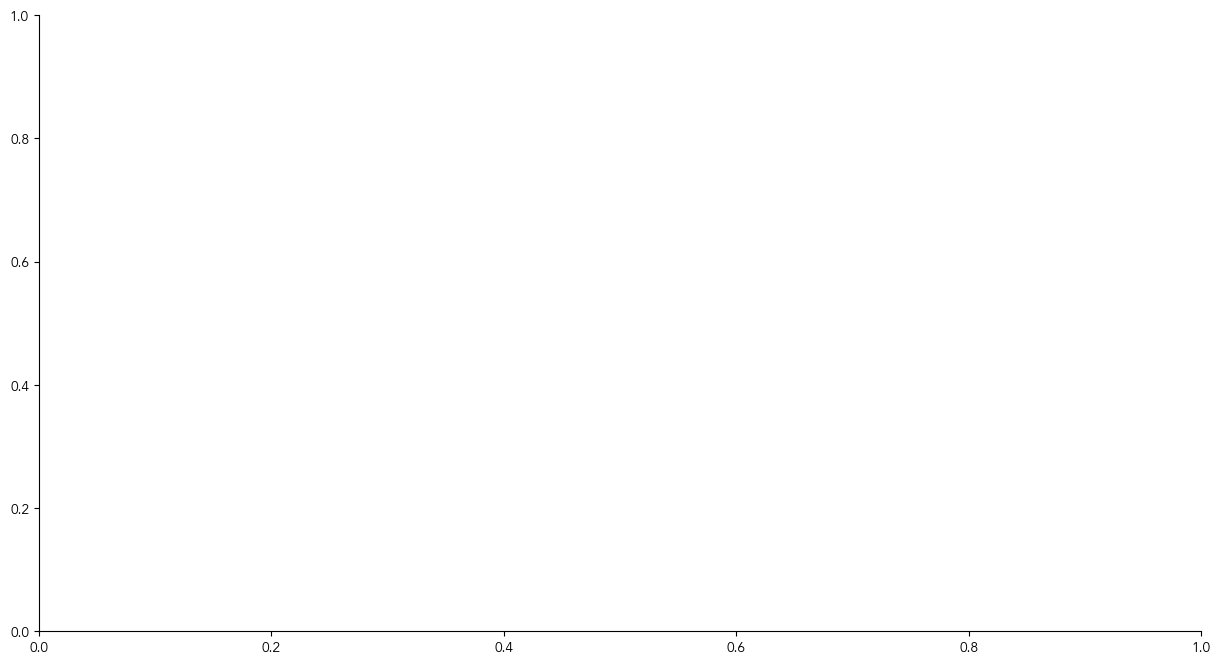

In [16]:
y1 = 'OilPressure0'

baseline_label = "1:57"
experiment_label = "1:50"

fig, axes = plt.subplots(len(sessions), 1, figsize=(15,8))

axes.flatten()

for i, session in enumerate(sessions):
    df = session.fastest_lap
    # create a dual axis plot if desired
    
    primary = axes[i]
    secondary = primary.twinx()

    primary.set_title(session.label, fontsize=14)

    primary.set_xlabel("")
    
    sns.lineplot(ax = secondary, x = df.index, y = y1, data = df, lw = 1, color='blue', label = "Oil Pressure (psi)", legend=False)
    sns.lineplot(ax = primary, x = df.index, y = 'RPM', data = df, lw = 1, color='lightgray', label = "RPM", legend=False)
    primary.set_ylim([4000,7500])

    secondary.set_ylim([30,85])
    secondary.set_ylabel('Oil Pressure (psi)')
    
    primary.legend(loc='lower left')
    secondary.legend(loc='lower right')

    # hide x axis units
    primary.set_xticklabels([])
    primary.set(xticks=[])
    primary.set_xlabel('Time')
    
fig.subplots_adjust(hspace=0.5)
fig.savefig(f'./figures/oilp-raw.png', bbox_inches='tight', facecolor='w', dpi=300)

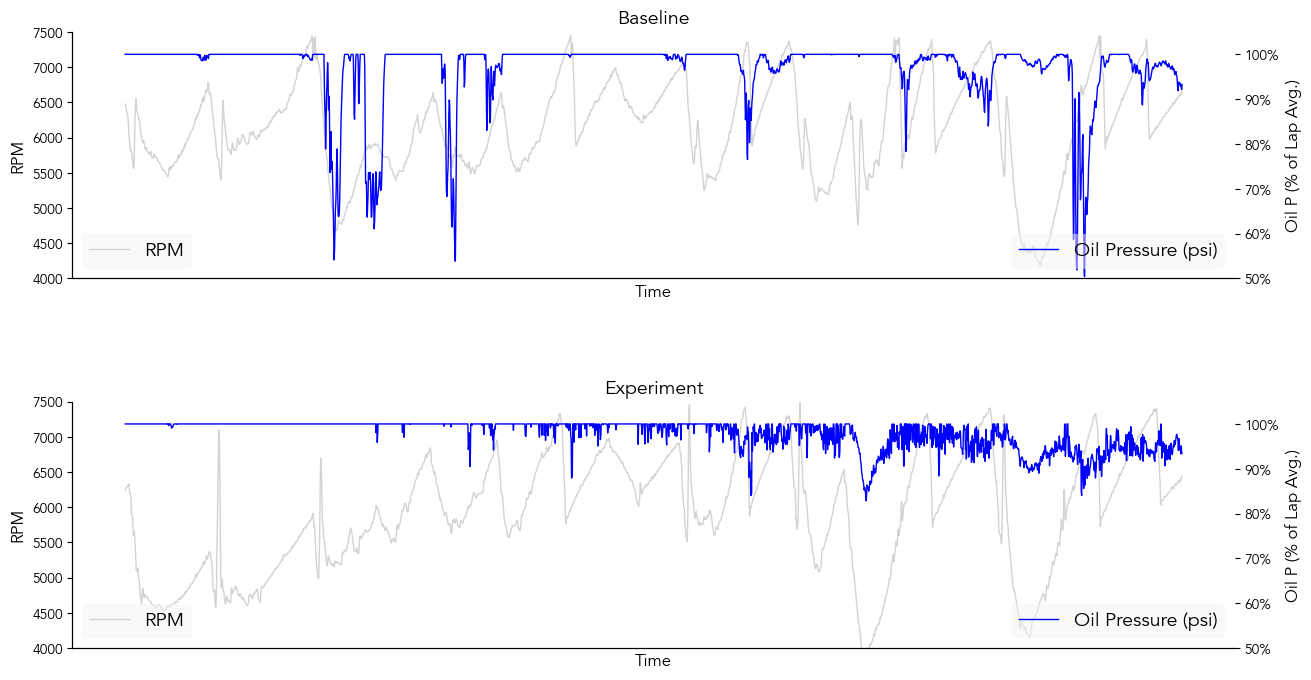

In [7]:
oil_p_name = 'OilPressure0'

fig, axes = plt.subplots(len(sessions), 1, figsize=(15,8))

axes.flatten()

for i, session in enumerate(sessions):
    df = session.fastest_lap

    lat_accel = axes[i]
    oil_p = lat_accel.twinx()

    avg_pressure = df.loc[df[y1] > 50][y1].mean()

    df["drop"] = df[y1].clip(lower=None, upper=avg_pressure) / avg_pressure
    
    sns.lineplot(ax = lat_accel, x = df.index, y = "RPM", data = df, lw = 1, color='lightgray', label = "RPM", legend=False)
    sns.lineplot(ax = oil_p, x = df.index, y = "drop", data = df, lw = 1, color='blue', label = "Oil Pressure (psi)", legend=False)

    lat_accel.set_title(session.label, fontsize=14)

    oil_p.set_ylim([.5,1.05])
    lat_accel.set_ylim([4000,7500])

    lat_accel.legend(loc='lower left')
    oil_p.legend(loc='lower right')

    # hide x axis units
    primary.set_xticklabels([])
    primary.set(xticks=[])
    primary.set_xlabel('')

    lat_accel.set_xlabel("Time")
    lat_accel.set_xticklabels([])
    lat_accel.set(xticks=[])

    oil_p.set_yticks([1, .9, .8, .7, .6, .5])
    oil_p.set_yticklabels(["100%", "90%", "80%", "70%", "60%", "50%"])
    oil_p.set_ylabel('Oil P (% of Lap Avg.)')
    
fig.subplots_adjust(hspace=0.5)
fig.savefig(f'./figures/oilp-normalized.png', bbox_inches='tight', facecolor='w', dpi=300)


# Correlations with rpm, oil temp

It is well established when oil pressure drops occur.
Some readings display right hand turns as negative Gs while others appear as positive Gs so it is always good to check.

Since oil pressure is also dependent on engine speed, it is good to factor in engine speed when examining low oil pressures

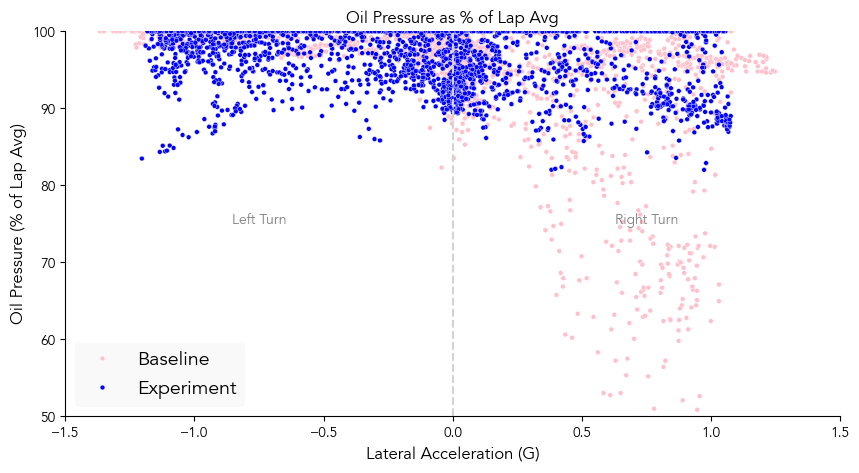

In [8]:
def normalize_pressure_drop(session: Session, label: str) -> pd.DataFrame:
    df = session.fastest_lap.query("RPM > 4000").copy()
    avg_pressure = df.loc[df[oil_p_name] > 70][oil_p_name].mean()
    df["drop"] = (df[oil_p_name].clip(lower=None, upper=avg_pressure) / avg_pressure) * 100
    df["label"] = label
    return df

session_data: list[pd.DataFrame] = []
color_palette: dict[str, str] = {}

# currently only supports two sessions
colors = ["pink", "blue"]

for i, session in enumerate(sessions):
    session_data.append(normalize_pressure_drop(session, label=session.label))
    color_palette[session.label] = colors[i]

fig, ax = plt.subplots(figsize=(10,5))

joined = pd.concat(session_data, ignore_index=True)

sns.scatterplot(ax = ax, x = "GPS LatAcc", y = 'drop', data = joined, hue="label", palette=color_palette, s=12, legend="auto")

ax.set_xlim([-1.5,1.5])
ax.set_title('Oil Pressure as % of Lap Avg')
ax.set_ylabel('Oil Pressure (% of Lap Avg)')
ax.set_xlabel('Lateral Acceleration (G)')
ax.set_ylim([50, 100])  # Set the y-axis limit to 0-100
ax.get_legend().set_title(None)

ax.axvline(x=0, color='lightgray', linestyle='--')

# Add text labels
ax.text(0.75, 75, 'Right Turn', horizontalalignment='center', color='gray')
ax.text(-0.75, 75, 'Left Turn', horizontalalignment='center', color='gray')


fig.savefig(f'./figures/oilp-scatter-lap.png', bbox_inches='tight', facecolor='w', dpi=300)
pass

# Plotting coordinates

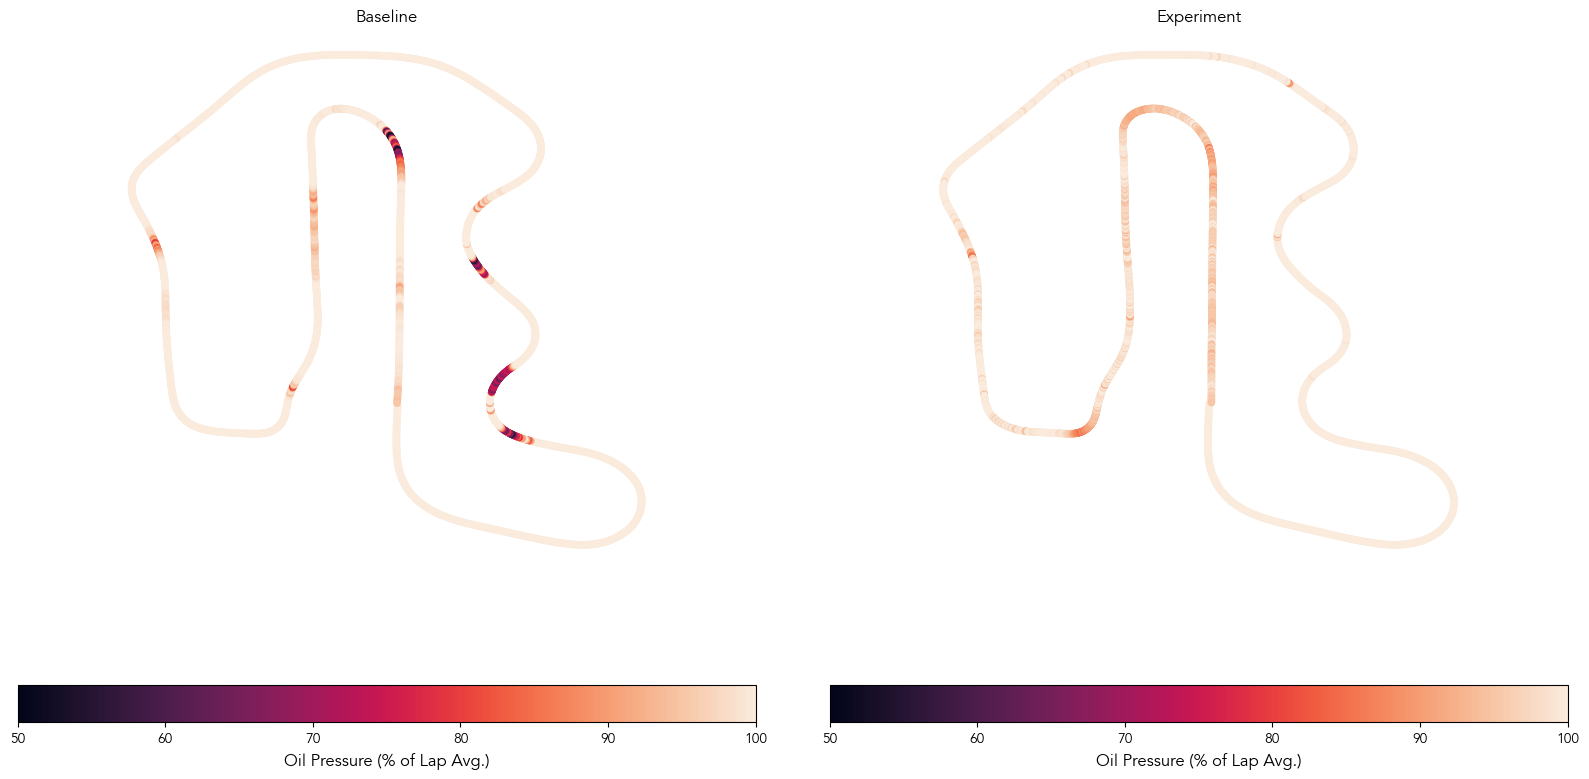

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
axs = ax.flatten()

for i, session in enumerate(sessions):
    df = session.fastest_lap.copy()
    avg_pressure = df.loc[df[oil_p_name] > 70][oil_p_name].mean() - 3 # subtract a small ammount to account for increasing temp over the course of a lap
    df["drop"] = (df[oil_p_name].clip(lower=None, upper=avg_pressure) / avg_pressure) * 100

    gdf = gpd.GeoDataFrame(data = df, geometry = gpd.points_from_xy(df['GPS Longitude'], df['GPS Latitude']))

    a = axs[i]
    data = gdf

    data.plot(ax = a, column = "drop", legend=True, vmin=50, vmax=100, cmap="rocket", label = "Oil Pressure (% of Lap Avg.)", markersize=20, legend_kwds={'label': "Oil Pressure (% of Lap Avg.)", 'orientation': "horizontal"})

    a.set_title(session.label)

    a.axis('off')

fig.subplots_adjust(wspace=.1)
fig.savefig(f'./figures/oilp-gps.png', bbox_inches='tight', facecolor='w', dpi=300)